In [1]:
import pandas as pd
import scipy.io as io
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import numpy as np
from matplotlib import gridspec
import seaborn as sns
import datetime
from datetime import datetime, timedelta
import pickle
import glob

In [2]:
import matplotlib.dates as dates
from scipy import stats
from sklearn import preprocessing
from scipy.signal import butter, filtfilt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
import matplotlib.pyplot as plt
font = {'family': 'sans-serif', 'serif': ['Helvetica']}
plt.rc('font', **font)
plt.rc('text', usetex=False)

In [4]:
label_fontsize = 16 
title_fontsize = 18

In [5]:
basefolderdir = "/rds/project/tb419/rds-tb419-bekinschtein/Sri/SpatialAttention_Drowsiness/"
inputfolderpath = basefolderdir + "drosSleepStages_SciAdvances2023/data/dlc_data/"

In [6]:
inputfolderpath

'/rds/project/tb419/rds-tb419-bekinschtein/Sri/SpatialAttention_Drowsiness/drosSleepStages_SciAdvances2023/data/dlc_data/'

In [7]:
flyname = '06_30102018_SponSleep_LFP'  #'02_27072018_SponSleep_LFP','03_14092018_SponSleep_LFP',
                                       #'04_17092018_SponSleep_LFP','06_30102018_SponSleep_LFP',
                                       #'07_01112018_SponSleep_LFP','08_03112018_SponSleep_LFP',
                                       #'09_13112018_SponSleep_LFP','12_28112018_SponSleep_LFP',
                                       #'14_11122018_SponSleep_LFP','16_18122018_SponSleep_LFP',
                                       #'17_10012019_SponSleep_LFP','18_17012019_SponSleep_LFP',
                                       #'19_22012019_SponSleep_LFP','21_20022019_SponSleep_LFP'

In [8]:
posefiles_dir = inputfolderpath + flyname + '/' + 'posetracked_files/'

In [9]:
posefiles_dir

'/rds/project/tb419/rds-tb419-bekinschtein/Sri/SpatialAttention_Drowsiness/drosSleepStages_SciAdvances2023/data/dlc_data/06_30102018_SponSleep_LFP/posetracked_files/'

In [10]:
posefiledlcname = []
for name in sorted(glob.glob(posefiles_dir + flyname[3:-4] + "*.h5")):
    posefiledlcname.append(name)
    print(name)

/rds/project/tb419/rds-tb419-bekinschtein/Sri/SpatialAttention_Drowsiness/drosSleepStages_SciAdvances2023/data/dlc_data/06_30102018_SponSleep_LFP/posetracked_files/30102018_SponSleep_LFP_01_DLC_resnet50_testDec13shuffle1_25100.h5
/rds/project/tb419/rds-tb419-bekinschtein/Sri/SpatialAttention_Drowsiness/drosSleepStages_SciAdvances2023/data/dlc_data/06_30102018_SponSleep_LFP/posetracked_files/30102018_SponSleep_LFP_02_DLC_resnet50_testDec13shuffle1_25100.h5
/rds/project/tb419/rds-tb419-bekinschtein/Sri/SpatialAttention_Drowsiness/drosSleepStages_SciAdvances2023/data/dlc_data/06_30102018_SponSleep_LFP/posetracked_files/30102018_SponSleep_LFP_03_DLC_resnet50_testDec13shuffle1_25100.h5
/rds/project/tb419/rds-tb419-bekinschtein/Sri/SpatialAttention_Drowsiness/drosSleepStages_SciAdvances2023/data/dlc_data/06_30102018_SponSleep_LFP/posetracked_files/30102018_SponSleep_LFP_04_DLC_resnet50_testDec13shuffle1_25100.h5
/rds/project/tb419/rds-tb419-bekinschtein/Sri/SpatialAttention_Drowsiness/drosSl

In [11]:
videocsvfiles_dir = basefolderdir + 'drosSleepStages_SciAdvances2023/data/beh_data/movement/' + flyname[3:] + '/'

In [12]:
videocsvfiles_dir

'/rds/project/tb419/rds-tb419-bekinschtein/Sri/SpatialAttention_Drowsiness/drosSleepStages_SciAdvances2023/data/beh_data/movement/30102018_SponSleep_LFP/'

In [13]:
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='lowpass', analog=False)
    return b, a

def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='highpass', analog=False)
    return b, a

def butter_bandpass_filt(data, cutoff1,cutoff2, fs, order=5):
    b, a = butter_lowpass(cutoff1, fs, order=order)
    y = filtfilt(b, a, data)
    #b, a = butter_highpass(cutoff2, fs, order=order)
    #y = filtfilt(b, a, y)
    return y

In [14]:
def getposes(hour):
    
    hourindex = int(hour)-1
    poseresults_file = posefiledlcname[hourindex] #posefiles_dir + h5filename
    print('\nprocessing: ', poseresults_file)
    print('\n')
    
    dlc_df = pd.read_hdf(poseresults_file)
    
    proboscis_df = dlc_df.xs('proboscis', level='bodyparts', axis=1)
    proboscis_df.columns = proboscis_df.columns.droplevel()
    
    eye_df = dlc_df.xs('eye', level='bodyparts', axis=1)
    eye_df.columns = eye_df.columns.droplevel()
    
    leg1tip_df = dlc_df.xs('leg1_joint', level='bodyparts', axis=1)
    leg1tip_df.columns = leg1tip_df.columns.droplevel()
    
    leg1joint_df = dlc_df.xs('leg1_tip', level='bodyparts', axis=1)
    leg1joint_df.columns = leg1joint_df.columns.droplevel()
    
    abdomen_df = dlc_df.xs('abdomen', level='bodyparts', axis=1)
    abdomen_df.columns = abdomen_df.columns.droplevel()
    
    return proboscis_df,eye_df,leg1tip_df,leg1joint_df,abdomen_df

In [15]:
def computefeatures(hour):
    
    proboscis_df,eye_df,leg1tip_df,leg1joint_df,abdomen_df = getposes(hour)
    
    
    #proboscis related stuff..
    proboscis_df.loc[:,'likelihood_filt'] = butter_bandpass_filt(proboscis_df.likelihood,cutoff1, cutoff2,fs)
    proboscis_df.loc[:,'x_filt'] = butter_bandpass_filt(proboscis_df.x, cutoff1, cutoff2,fs)
    proboscis_df.loc[:,'y_filt'] = butter_bandpass_filt(proboscis_df.y, cutoff1, cutoff2, fs)
    
    proboscis_df.loc[:,'likelihood_filtmov'] = np.convolve(proboscis_df.likelihood_filt, 
                                                           np.ones((nsamp,))/nsamp, mode='same')
    proboscis_df.loc[:,'x_filtmov'] = np.convolve(proboscis_df.x_filt, 
                                                  np.ones((nsamp,))/nsamp, mode='same')
    proboscis_df.loc[:,'y_filtmov'] = np.convolve(proboscis_df.y_filt, 
                                              np.ones((nsamp,))/nsamp, mode='same')
    
    #eye related stuff..
    eye_df.loc[:,'likelihood_filt'] = butter_bandpass_filt(eye_df.likelihood, cutoff1, cutoff2,fs)
    eye_df.loc[:,'x_filt'] = butter_bandpass_filt(eye_df.x, cutoff1, cutoff2,fs)
    eye_df.loc[:,'y_filt'] = butter_bandpass_filt(eye_df.y, cutoff1, cutoff2,fs)
    
    eye_df.loc[:,'likelihood_filtmov'] = np.convolve(eye_df.likelihood_filt, 
                                                     np.ones((nsamp,))/nsamp, mode='same')
    eye_df.loc[:,'x_filtmov'] = np.convolve(eye_df.x_filt, 
                                            np.ones((nsamp,))/nsamp, mode='same')
    eye_df.loc[:,'y_filtmov'] = np.convolve(eye_df.y_filt, 
                                            np.ones((nsamp,))/nsamp, mode='same')
    
    #leg1tip related stuff..
    leg1tip_df.loc[:,'likelihood_filt'] = butter_bandpass_filt(leg1tip_df.likelihood, cutoff1, cutoff2,fs)
    leg1tip_df.loc[:,'x_filt'] = butter_bandpass_filt(leg1tip_df.x, cutoff1, cutoff2,fs)
    leg1tip_df.loc[:,'y_filt'] = butter_bandpass_filt(leg1tip_df.y, cutoff1, cutoff2,fs)
    
    leg1tip_df.loc[:,'likelihood_filtmov'] = np.convolve(leg1tip_df.likelihood_filt, 
                                                         np.ones((nsamp,))/nsamp, mode='same')
    leg1tip_df.loc[:,'x_filtmov'] = np.convolve(leg1tip_df.x_filt, 
                                                np.ones((nsamp,))/nsamp, mode='same')
    leg1tip_df.loc[:,'y_filtmov'] = np.convolve(leg1tip_df.y_filt, 
                                                np.ones((nsamp,))/nsamp, mode='same')
    
    
    #leg1joint related stuff..
    leg1joint_df.loc[:,'likelihood_filt'] = butter_bandpass_filt(leg1joint_df.likelihood, cutoff1, cutoff2,fs)
    leg1joint_df.loc[:,'x_filt'] = butter_bandpass_filt(leg1joint_df.x, cutoff1, cutoff2,fs)
    leg1joint_df.loc[:,'y_filt'] = butter_bandpass_filt(leg1joint_df.y, cutoff1, cutoff2,fs)
    
    leg1joint_df.loc[:,'likelihood_filtmov'] = np.convolve(leg1joint_df.likelihood_filt, 
                                                           np.ones((nsamp,))/nsamp, mode='same')
    leg1joint_df.loc[:,'x_filtmov'] = np.convolve(leg1joint_df.x_filt, 
                                              np.ones((nsamp,))/nsamp, mode='same')
    leg1joint_df.loc[:,'y_filtmov'] = np.convolve(leg1joint_df.y_filt, 
                                              np.ones((nsamp,))/nsamp, mode='same')
    
    #abdomen related stuff..
    abdomen_df.loc[:,'likelihood_filt'] = butter_bandpass_filt(abdomen_df.likelihood, cutoff1, cutoff2,fs)
    abdomen_df.loc[:,'x_filt'] = butter_bandpass_filt(abdomen_df.x, cutoff1, cutoff2,fs)
    abdomen_df.loc[:,'y_filt'] = butter_bandpass_filt(abdomen_df.y, cutoff1, cutoff2,fs)
    
    abdomen_df.loc[:,'likelihood_filtmov'] = np.convolve(abdomen_df.likelihood_filt, 
                                                         np.ones((nsamp,))/nsamp, mode='same')
    abdomen_df.loc[:,'x_filtmov'] = np.convolve(abdomen_df.x_filt, 
                                                np.ones((nsamp,))/nsamp, mode='same')
    abdomen_df.loc[:,'y_filtmov'] = np.convolve(abdomen_df.y_filt, 
                                                np.ones((nsamp,))/nsamp, mode='same')
    
    
    #rename columns..
    proboscis_df.columns = ['x_prob', 'y_prob', 'like_prob', 
                            'likefilt_prob','xfilt_prob', 'yfilt_prob',
                            'likefiltmov_prob','xfiltmov_prob', 'yfiltmov_prob']
    eye_df.columns =       ['x_eye', 'y_eye', 'like_eye', 
                            'likefilt_eye','xfilt_eye', 'yfilt_eye',
                            'likefiltmov_eye','xfiltmov_eye', 'yfiltmov_eye']
    leg1tip_df.columns =   ['x_leg1tip', 'y_leg1tip', 'like_leg1tip', 
                            'likefilt_leg1tip','xfilt_leg1tip', 'yfilt_leg1tip',
                            'likefiltmov_leg1tip','xfiltmov_leg1tip', 'yfiltmov_leg1tip']
    leg1joint_df.columns = ['x_leg1joint', 'y_leg1joint', 'like_leg1joint', 
                            'likefilt_leg1joint','xfilt_leg1joint', 'yfilt_leg1joint',
                            'likefiltmov_leg1joint','xfiltmov_leg1joint', 'yfiltmov_leg1joint']
    abdomen_df.columns =   ['x_abdomen', 'y_abdomen', 'like_abdomen', 
                            'likefilt_abdomen','xfilt_abdomen', 'yfilt_abdomen',
                            'likefiltmov_abdomen','xfiltmov_abdomen', 'yfiltmov_abdomen']
    
    
    #collect features..
    features_df = pd.concat([proboscis_df[['likefilt_prob','xfilt_prob','yfilt_prob']],
                         eye_df[['likefilt_eye','xfilt_eye','yfilt_eye']],
                         leg1tip_df[['likefilt_leg1tip','xfilt_leg1tip','yfilt_leg1tip']],
                         leg1joint_df[['likefilt_leg1joint','xfilt_leg1joint','yfilt_leg1joint']],
                         abdomen_df[['likefilt_abdomen','xfilt_abdomen','yfilt_abdomen']],
                        ], axis=1)

    features_df['dist_eyeprob'] = np.sqrt((features_df.xfilt_prob - features_df.xfilt_eye) ** 2 +
                                  (features_df.yfilt_prob - features_df.yfilt_eye) ** 2)
    features_df['dist_eyeprob'] = features_df['dist_eyeprob']*features_df['likefilt_prob']
    
    
    
    return features_df

In [16]:
def processfeatures(hour):
    
    features_df = computefeatures(hour)
    
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(features_df.values)
    
    scaled_data_df = pd.DataFrame.from_records(scaled_data)
    scaled_data_df.columns = features_df.columns

    return scaled_data, scaled_data_df

In [17]:
def processvideocsv(hour):
    
    videocsvfilename = flyname[3:] + '_' + hour + '_.csv'  #'_24Hrs_','_LFP_'
    videocsv_file = videocsvfiles_dir + videocsvfilename
    print('\nusing video csv file: ', videocsv_file)
    video_df = pd.read_csv(videocsv_file)
    
    video_df['disptime1'] = video_df[['Year', 'Month','Date']].apply(lambda x: '-'.join(x.map(str)), axis=1)
    video_df['disptime2'] = video_df[['Hour', 'Mins','Seconds']].apply(lambda x: ':'.join(x.map(str)), axis=1)
    video_df['disptime'] = video_df['disptime1'] + ' ' + video_df['disptime2'] 
    video_df = video_df.drop(['disptime1', 'disptime2'], axis=1)
    video_df['disptime'] =  pd.to_datetime(video_df['disptime'], format='%Y-%m-%d %H:%M:%S')
    
    video_df['time'] = video_df['Hour']*3600 + video_df['Mins']*60 + video_df['Seconds'] +\
                       video_df['usec']*(10**-6)
    
    labels_df = []
    labels_df = pd.DataFrame(video_df['disptime'])
    labels_df['behavior'] = 0
    labels_df['framenum'] = labels_df.index
    labels_df['framenum'] = labels_df['framenum']+1
    
    return video_df,labels_df

In [18]:
def processbehannotation(annotatelabel, hour):
    
    behcsv_file = inputfolderpath + flyname + '/' + flyname[3:] + '_beh_annotation.csv'
    print('\nusing beh annotation file: ', behcsv_file)
    beh_df = pd.read_csv(behcsv_file)
    
    beh_df = beh_df.dropna()
    
    beh_df = beh_df[beh_df.hour_idx == int(hour)]
    
    beh_df['starttime'] =  pd.to_datetime(beh_df['starttime'], format='%Y-%m-%d %H:%M:%S')
    beh_df['stoptime'] =  pd.to_datetime(beh_df['stoptime'], format='%Y-%m-%d %H:%M:%S')
    beh_df['difftime'] = np.where(beh_df['stoptime'] > beh_df['starttime'], True, False)
    
    beh_df = beh_df[beh_df['activity'] == annotatelabel]
    beh_df = beh_df.reset_index(drop=True)
    
    return beh_df 

In [19]:
cutoff1 = 0.1  #10,20
cutoff2 = 0.01 #1
fs = 30 #3000
#number of samples for moving mean..
nsamp = 5

In [20]:
hourstoanalyse = ['08'] #'01' #'01','02', '07', '08','02','03'

In [21]:
annotatelabel = 'prob'

In [22]:
for houridx, hourval in enumerate(hourstoanalyse):
    print('Analysing hour: ',hourval)
    scaled_data, scaled_data_df = processfeatures(hourval)
    video_df,labels_df = processvideocsv(hourval)
    beh_df = processbehannotation(annotatelabel,hourval)
    if houridx == 0:
        allscaled_data = scaled_data
        allscaled_data_df = scaled_data_df
        allvideo_df = video_df
        alllabels_df = labels_df
        allbeh_df = beh_df
    else:
        allscaled_data = np.vstack([allscaled_data,scaled_data])
        allscaled_data_df = allscaled_data_df.append(scaled_data_df)
        allvideo_df = allvideo_df.append(video_df)
        alllabels_df = alllabels_df.append(labels_df)
        allbeh_df = allbeh_df.append(beh_df)

Analysing hour:  08

processing:  /rds/project/tb419/rds-tb419-bekinschtein/Sri/SpatialAttention_Drowsiness/drosSleepStages_SciAdvances2023/data/dlc_data/06_30102018_SponSleep_LFP/posetracked_files/30102018_SponSleep_LFP_08_DLC_resnet50_testDec13shuffle1_25100.h5



using video csv file:  /rds/project/tb419/rds-tb419-bekinschtein/Sri/SpatialAttention_Drowsiness/drosSleepStages_SciAdvances2023/data/beh_data/movement/30102018_SponSleep_LFP/30102018_SponSleep_LFP_08_.csv

using beh annotation file:  /rds/project/tb419/rds-tb419-bekinschtein/Sri/SpatialAttention_Drowsiness/drosSleepStages_SciAdvances2023/data/dlc_data/06_30102018_SponSleep_LFP/30102018_SponSleep_LFP_beh_annotation.csv


In [23]:
allscaled_data_df = allscaled_data_df.reset_index(drop=True)
allvideo_df = allvideo_df.reset_index(drop=True)
alllabels_df = alllabels_df.reset_index(drop=True)
allbeh_df = allbeh_df.reset_index(drop=True)

In [24]:
overallstarttime = allbeh_df.starttime.iloc[0] - timedelta(seconds=1800)  #seconds=10
overallstarttime

Timestamp('2018-10-31 03:12:46')

In [25]:
overallstoptime = allbeh_df.stoptime.iloc[-1] + timedelta(seconds=10)   #seconds=10
overallstoptime

Timestamp('2018-10-31 03:53:48')

In [26]:
selectindx = ((alllabels_df.disptime >= overallstarttime) &
             (alllabels_df.disptime <= overallstoptime))

In [27]:
allscaled_data = allscaled_data[selectindx]
allscaled_data_df = allscaled_data_df.loc[selectindx,:]
allvideo_df = allvideo_df.loc[selectindx,:]
alllabels_df = alllabels_df.loc[selectindx,:]

In [28]:
allscaled_data_df = allscaled_data_df.reset_index(drop=True)
allvideo_df = allvideo_df.reset_index(drop=True)
alllabels_df = alllabels_df.reset_index(drop=True)
allbeh_df = allbeh_df.reset_index(drop=True)

In [29]:
alllabels_df

,disptime,behavior,framenum
0,2018-10-31 03:42:29,0,1
1,2018-10-31 03:42:29,0,2
2,2018-10-31 03:42:29,0,3
3,2018-10-31 03:42:29,0,4
4,2018-10-31 03:42:29,0,5
...,...,...,...
18751,2018-10-31 03:53:48,0,18752
18752,2018-10-31 03:53:48,0,18753
18753,2018-10-31 03:53:48,0,18754
18754,2018-10-31 03:53:48,0,18755


In [30]:
allscaled_data_df

,likefilt_prob,xfilt_prob,yfilt_prob,likefilt_eye,xfilt_eye,yfilt_eye,likefilt_leg1tip,xfilt_leg1tip,yfilt_leg1tip,likefilt_leg1joint,xfilt_leg1joint,yfilt_leg1joint,likefilt_abdomen,xfilt_abdomen,yfilt_abdomen,dist_eyeprob
0,1.131021,-0.538011,0.461344,0.947763,0.646923,-0.791752,0.450657,0.068398,-0.654973,0.439526,0.576007,-0.077362,0.283455,0.632222,0.119802,0.872922
1,1.123644,-0.537439,0.461559,0.948982,0.642584,-0.787537,0.450664,0.072783,-0.653211,0.439536,0.579622,-0.079068,0.283476,0.632290,0.118145,0.866736
2,1.116290,-0.536867,0.461770,0.950204,0.638268,-0.783370,0.450670,0.077171,-0.651452,0.439546,0.583231,-0.080772,0.283499,0.632347,0.116483,0.860568
3,1.108962,-0.536296,0.461980,0.951427,0.633973,-0.779252,0.450677,0.081561,-0.649694,0.439555,0.586833,-0.082471,0.283523,0.632393,0.114815,0.854419
4,1.101660,-0.535727,0.462187,0.952651,0.629702,-0.775185,0.450683,0.085953,-0.647939,0.439565,0.590428,-0.084167,0.283548,0.632427,0.113143,0.848291
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18751,-0.440043,1.492472,-1.820065,-0.838345,0.966559,0.187228,-4.015349,2.388219,-3.194745,-4.565275,0.148639,-0.143597,0.003456,-2.934294,-0.860266,-0.091900
18752,-0.436627,1.477310,-1.807965,-0.830408,0.963024,0.185327,-3.984177,2.337520,-3.152418,-4.537225,0.151564,-0.138143,0.005583,-2.930101,-0.834491,-0.087451
18753,-0.433272,1.462008,-1.795682,-0.822416,0.959355,0.183509,-3.952794,2.287111,-3.110197,-4.508950,0.154535,-0.132688,0.007668,-2.925694,-0.808408,-0.083353
18754,-0.429980,1.446567,-1.783220,-0.814369,0.955553,0.181773,-3.921205,2.237000,-3.068092,-4.480453,0.157551,-0.127231,0.009712,-2.921075,-0.782023,-0.079605


In [31]:
allvideo_df

,Year,Month,Date,Hour,Mins,Seconds,usec,nFrames,disptime,time
0,2018,10,31,3,42,29,238000,1,2018-10-31 03:42:29,13349.238
1,2018,10,31,3,42,29,274000,2,2018-10-31 03:42:29,13349.274
2,2018,10,31,3,42,29,309000,3,2018-10-31 03:42:29,13349.309
3,2018,10,31,3,42,29,345000,4,2018-10-31 03:42:29,13349.345
4,2018,10,31,3,42,29,381000,5,2018-10-31 03:42:29,13349.381
...,...,...,...,...,...,...,...,...,...,...
18751,2018,10,31,3,53,48,833000,18752,2018-10-31 03:53:48,14028.833
18752,2018,10,31,3,53,48,869000,18753,2018-10-31 03:53:48,14028.869
18753,2018,10,31,3,53,48,905000,18754,2018-10-31 03:53:48,14028.905
18754,2018,10,31,3,53,48,942000,18755,2018-10-31 03:53:48,14028.942


## Start plotting features..

In [32]:
plotbeh_df = beh_df.copy()

In [33]:
start_time = pd.to_datetime('2018-10-31 3:45:00', format='%Y-%m-%d %H:%M:%S')
stop_time =  pd.to_datetime('2018-10-31 4:00:00', format='%Y-%m-%d %H:%M:%S') # add 30 mins to the start_time

In [34]:
print('from : ',start_time)
print('to   : ',stop_time)

from :  2018-10-31 03:45:00
to   :  2018-10-31 04:00:00


In [35]:
selectindx = ((alllabels_df.disptime >= start_time) &
             (alllabels_df.disptime <= stop_time))

In [36]:
plotlabels_df = alllabels_df.loc[selectindx]

plotlabels_df.loc[:,'xfilt_prob'] = allscaled_data_df.loc[selectindx, 'xfilt_prob']

plotlabels_df.loc[:,'yfilt_prob'] = allscaled_data_df.loc[selectindx, 'yfilt_prob']

plotlabels_df.loc[:,'likefilt_prob'] = allscaled_data_df.loc[selectindx, 'likefilt_prob']

plotlabels_df.loc[:,'dist_eyeprob'] = allscaled_data_df.loc[selectindx, 'dist_eyeprob']

plotlabels_df.loc[:,'disptime'] = pd.to_datetime(plotlabels_df['disptime']).dt.strftime('%H:%M:%S')

plotlabels_df

/home/srj34/deeplabcut-env/lib/python3.6/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/srj34/deeplabcut-env/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


,disptime,behavior,framenum,xfilt_prob,yfilt_prob,likefilt_prob,dist_eyeprob
4158,03:45:00,0,4159,-0.633842,0.389867,0.361758,0.116351
4159,03:45:00,0,4160,-0.633928,0.389876,0.363683,0.117855
4160,03:45:00,0,4161,-0.634016,0.389882,0.365641,0.119382
4161,03:45:00,0,4162,-0.634106,0.389882,0.367631,0.120929
4162,03:45:00,0,4163,-0.634198,0.389877,0.369654,0.122497
...,...,...,...,...,...,...,...
18751,03:53:48,0,18752,1.492472,-1.820065,-0.440043,-0.091900
18752,03:53:48,0,18753,1.477310,-1.807965,-0.436627,-0.087451
18753,03:53:48,0,18754,1.462008,-1.795682,-0.433272,-0.083353
18754,03:53:48,0,18755,1.446567,-1.783220,-0.429980,-0.079605


In [37]:
import matplotlib.patches as patches

/home/srj34/deeplabcut-env/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/home/srj34/deeplabcut-env/lib/python3.6/site-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/srj34/deeplabcut-env/lib/python3.6/site-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


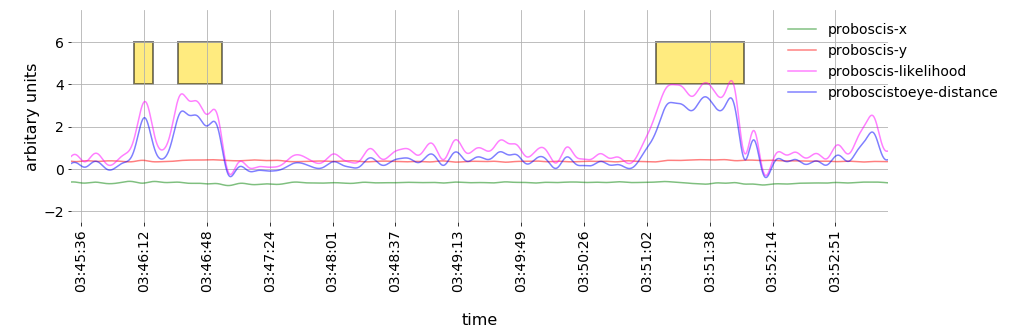

In [38]:
fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(plotlabels_df.index,plotlabels_df['xfilt_prob'],color='green', alpha = 0.5)

ax.plot(plotlabels_df.index,plotlabels_df['yfilt_prob'],color='red', alpha = 0.5)

ax.plot(plotlabels_df.index,plotlabels_df['likefilt_prob'],color='magenta', alpha = 0.5)


ax.plot(plotlabels_df.index,plotlabels_df['dist_eyeprob'],color='blue', alpha = 0.5)


plt.xticks(plotlabels_df.index[0::1000],plotlabels_df["disptime"].values[0::1000])
plt.setp(ax.get_xticklabels(), rotation=90)

ax.margins(x=0)

sns.despine(left=True, bottom = True)



ax.add_patch(patches.Rectangle(xy=(6000, 4),  # point of origin.
                               width=300, height=2, linewidth=2,
                              color='#ffd801', ec = 'k', fill=True, alpha = 0.5))


ax.add_patch(patches.Rectangle(xy=(6700, 4),  # point of origin.
                               width=700, height=2, linewidth=2,
                              color='#ffd801', ec = 'k', fill=True, alpha = 0.5))


ax.add_patch(patches.Rectangle(xy=(14300, 4),  # point of origin.
                               width=1400, height=2, linewidth=2,
                              color='#ffd801', ec = 'k', fill=True, alpha = 0.5))


ax.set_ylim([-2.5, 7.5])

plt.tight_layout()
plt.box(False)
plt.grid(True)

ax.set_ylabel('\narbitary units', fontsize=label_fontsize)
ax.set_xlabel('\ntime', fontsize=label_fontsize)
ax.tick_params(axis='both', which='major', labelsize=label_fontsize-2)
ax.set_xlim([5000, 18000])

plt.legend(labels=['proboscis-x', 'proboscis-y', 'proboscis-likelihood', 'proboscistoeye-distance'],
          loc="upper right",frameon=False, fontsize=label_fontsize-2, bbox_to_anchor=(1.15, 1.0))